2D propagation of a cylindrical wave is given by:

$$
U_o\left(x_o\right)=\frac{i \pi}{\lambda} \int_{-\infty}^{\infty} U_s\left(x_s\right) \frac{z}{r_{o s}} H_1^{(1)}\left(k r_{o s}\right) \mathrm{d} x_s,
$$

The amplitude of $ H_1^{(1)} $ (a Hankel function of the first kind) can be approximated by $ \sqrt{\frac{2}{\pi k r}} $ (see https://dlmf.nist.gov/10.2#E5). 

If $U_s\left(x_s\right)$ is a point source, we can use a Dirac Delta function to solve for $U_o\left(x_o\right)$, (since integral of Dirac Delta function is 1), and after some algebra we can find the intensity of the wavefront as: 

$$
I = |U_o\left(z, r\right)|^{2} = \frac{z^{2}}{\lambda r^{3}}
$$

altenatively, $\cos(\theta) = \frac{z}{r}$, thus:

$$
I = |U_o\left(\theta, r\right)|^{2} = \frac{\cos(\theta)^{2}}{\lambda r}
$$


where r is some euclidean distance to a point, and z is the perpendicular distance to the plane of that point.

The first note to make about this point source function is that, there should be no backwards propagation. So all of the power of the wavefront should be contained within the half cylinder (cylinder because we are in a 2D plane) that propagates from the "point source" forward. Therefore, if we propagate this wave forward, and know that we had a power of "1" (arbitrary units) at the source, we should measure a power of 1 if we integrate the power density on the surface of the semi circle some distance away. Let's first test this hypothesis. 

Knowing this, we should then try and figure out what "power" needs to be applied to each ray, so that we can propagate many rays leaving the point source, and add them together on the screen to obtain the same intensity. I will for now forget about Marco Mout's thesis, as his method I just cannot understand fully, only partially, and thus it is hard to get to work. His method does however have a great advantage if I can get it to work: the computation does not need to be stopped as far as I understand every time an aperture is reached and diffraction is caused, rays can continue to propagate without stopping to know what the intensity at the aperture should have been, since each ray locally knows it's amplitude, and can carry that forward independently. This is possible because in his description, rays propagate a little infinitesimal area of the wavefront, although knowing what that infinitesimal area should be for different wavefront shapes is non-trivial. 

Anyway, for the power calculation, if the power of a wavefront is given $ P = \int{I dl}$, where I is again intensity, and $dl$ is a little line element on a surface of the wavefront, then if we have a circular wavefront, $dl = r \times d \theta$. Thus, after integration, the power of the wavefront is: 

$P = \frac{\pi}{2\lambda}$. A weird result, but if we choose $\lambda$ = \frac{2}{\pi}$ then we will have a power of 1. I don't quite understand this result but whatever. It works for us for now. 

Let's try and plot this point source propagation on a 2D grid, and check that power is conserved. Then we will try and approximate the result with rays later. 



In [789]:
import scipy.integrate
import matplotlib.pyplot as plt
import numpy as np

%matplotlib ipympl
def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = np.eye(2)

    y_transformed, x_transformed = (np.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)

In [790]:

# Set up coordinates
det_px = 201
x_extent = 500
z_prop = 1000
x, dx = np.linspace(-x_extent, x_extent, det_px, retstep=True)
z, dz = np.linspace(0.5, z_prop, 1001, retstep=True)
xx, zz = np.meshgrid(x, z)
r = np.sqrt(xx**2 + zz**2)

# Calculate wavelength to give us "1" at the source
P = 1 #watt
wavelength = np.pi / (2 * P) 
k = (2 * np.pi / wavelength)

U_Det = (zz / r) * (1 / np.sqrt(r)) #(0.5j * k * zz / r) *  np.sqrt(2 / (np.pi * k * r))

# Choose circle radius to check power density calculation
r_circ = 0.5

# Set up coordinates
theta_indices, dtheta = np.linspace(0, -np.pi, det_px, retstep=True)
xx_indices = r_circ * np.cos(theta_indices)
zz_indices = r_circ * -np.sin(theta_indices)
r_indices = np.sqrt(xx_indices**2 + zz_indices**2)

U0 = 1.0
U_Circ = np.cos(theta_indices) / np.sqrt(r_circ)  # (0.5j * k) *  np.sqrt(2 / (np.pi * k)) * 
I_Circ = np.abs(U_Circ) ** 2

Circular_Power = scipy.integrate.simpson(y=I_Circ, x=np.abs(theta_indices)) * r_circ
print('Circular Power = ', Circular_Power)
print('U0 =', np.cos(0) / np.sqrt(r_circ))

Circular Power =  1.5707963267948963
U0 = 1.414213562373095


The figure above is the intensity recorded on a detector 1000 um away from the point source. We should be able to use this to work what we need to do to each ray so that it has the correct amplitude to give us this intensity. 

[0.001] 0.0009999999999999998


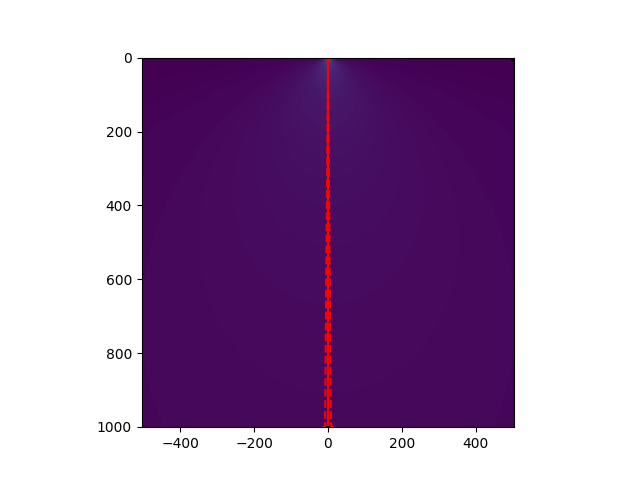

In [791]:
plt.figure()

extent = [x[0]-dx, x[-1]+dx, z[-1]+dz, z[0]-dz]
plt.imshow((np.abs(U_Det)), extent=extent, cmap='viridis')
plt.plot(xx_indices, zz_indices, '-r')
plt.plot(500, 0.0, '.k')

ray_aper_coord = np.array([[0], [0]])
ray_det_x = np.random.uniform(0, 0, 1)
ray_det_z = np.ones(1) * 1000

ray_det_coord = np.array([ray_det_z, ray_det_x])

ray_vec = ray_det_coord - ray_aper_coord
ray_vec_mag = np.linalg.norm(ray_vec, axis = 0)
ray_vec_dir = ray_vec / ray_vec_mag

theta = np.arctan(ray_det_x / ray_det_z)[0]
delta_theta = np.pi / (200)

area_element_triangle_source = 2 * r_circ * np.sin(delta_theta/2)
area_element_triangle_det = 2 * 1000 * np.sin(delta_theta/2)

# Uncomment np.cos(delta_theta / 2) to get coordinates on circle, but error is small anyway
dtheta_left_x = -r_circ * np.sin(delta_theta / 2)
dtheta_left_z = r_circ #* np.cos(delta_theta / 2)
dtheta_right_x = r_circ * np.sin(delta_theta / 2)
dtheta_right_z = r_circ #* np.cos(delta_theta / 2)

det_left_x = -1000 * np.sin(theta + delta_theta / 2)
det_left_z = 1000 #* np.cos(delta_theta / 2)
det_right_x = 1000 * np.sin(theta + delta_theta / 2)
det_right_z = 1000 #* np.cos(delta_theta / 2)

U0 = np.cos(theta) / np.sqrt(r_circ)
I0 = U0**2

I1 = (I0 * (r_circ / (ray_vec_mag)))

I1_area = I0 * (area_element_triangle_source / area_element_triangle_det) * np.cos(theta)
print(I1, I1_area)

plt.arrow(ray_aper_coord[1][0], ray_aper_coord[0][0], ray_vec[1][0], ray_vec[0][0], fc='red', ec='red', 
          head_width=0.1, head_length=0.2, length_includes_head=True)

plt.plot(dtheta_left_x, dtheta_left_z, '.r')
plt.plot(dtheta_right_x, dtheta_right_z, '.r')
plt.plot([dtheta_left_x, dtheta_right_x], [dtheta_left_z, dtheta_right_z], '--k')

plt.plot(det_left_x, det_left_z, '.r')
plt.plot(det_right_x, det_right_z, '.r')
plt.plot([det_left_x, det_right_x], [det_left_z, det_right_z], '--k')

plt.plot([0, det_right_x], [0, det_right_z], '--r')
plt.plot([0, det_left_x], [0, det_left_z], '--r')


Text(0, 0.5, 'Intensity')

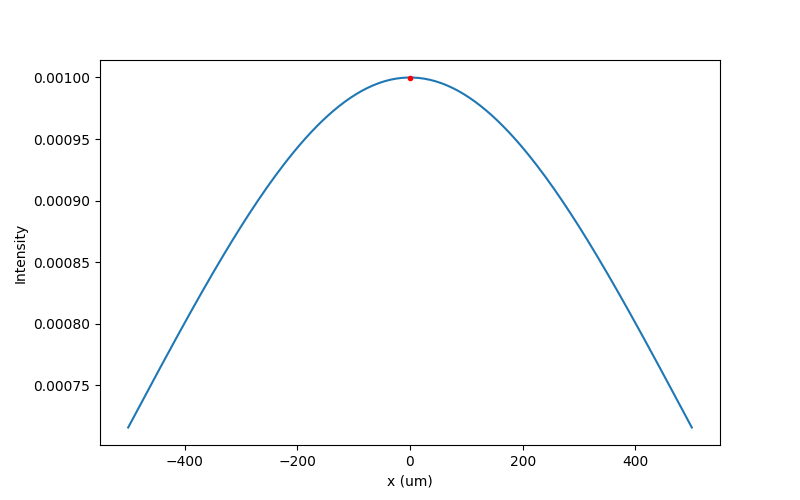

In [792]:
plt.figure(figsize = (8, 5))
plt.plot(x, np.abs(U_Det[-1, :]) ** 2)
plt.plot(ray_det_x, I1_area, '.r')
plt.xlabel('x (um)')
plt.ylabel('Intensity')


This figure just shows the point source amplitude, and the semi-cylinder that we use to find out if we have a power of 1 when we integrate this cylinder. This is the case. 

Now how can we replicate the intensity of the figure above using a monte carlo ray tracing implementation of this point source? The naive method might be the best first port of call - what if we say that we have N rays leaving the point source, and each one carries with it an amplitude of $\sqrt(1 / N)$. How can we then add all of these rays together in a pixel to get the intensity recorded above?. We should concentrate first on trying to recreate a single value in the centre of the plot first of all. So therefore we need to calculate how many rays will go through the pixel directly in front, so we can supply each with the appropriate amplitude.  

I know how to do this, Now we need to assign a little area to each ray leaving the point source. This can be done by selecting a small circle around the point source, and calculating the area of that circle that each ray should represent. 

Text(0, 0.5, 'Intensity')

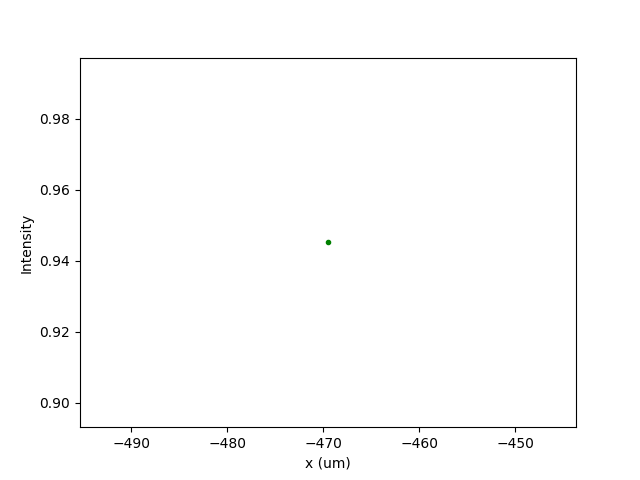

In [793]:
N = 100

z_det = 1000

det_vec = np.array([[1, 0]])
ray_aper_coord = np.array([[0], [0]])
ray_det_x = np.random.uniform(x[0], x[-1], 1)
ray_det_z = np.ones(1) * z_det

ray_det_coord = np.array([ray_det_z, ray_det_x])

ray_vec = ray_det_coord - ray_aper_coord
ray_vec_mag = np.linalg.norm(ray_vec, axis = 0)
ray_vec_dir = ray_vec / ray_vec_mag

ray_angle = np.arctan2(ray_vec_dir[1, :], ray_vec_dir[0, :])

factor = 1 #1j * np.sqrt(wavelength) / (wavelength * np.sqrt(ray_vec_mag))

dN0 = 1 # Number of rays per pixel in point source
dN1 = 1 # Number of rays per pixel in detector plane

r_circ = 1.0
delta_theta = np.pi / (100)

dS0 = 2 * r_circ * np.sin(delta_theta/2)
dS1 =  (2 * ray_vec_mag * np.sin(delta_theta/2))  * np.dot(ray_vec_dir.T, det_vec.T)

# See Chapter 2 of Marco Mout thesis - 2.97 onwards
ws = np.sqrt((N * dS0) / dN0)  * np.dot(ray_vec_dir.T, det_vec.T)
wp = np.sqrt((N * dS1) / dN1)
wi = np.sqrt(1 / (np.dot(ray_vec_dir.T, det_vec.T)))

U_rays = np.abs(1 * ws * wp * wi) / N

plt.figure()
# plt.plot(x, np.abs(U_Det[-1, :]))
plt.plot(ray_det_x, U_rays, '.g')
plt.xlabel('x (um)')
plt.ylabel('Intensity')

Now that we can propagate rays from a point source, to a point on a detector plane, we now need to propagate a tube of rays to a pixel, and obtain the right intensity in the pixel. This should just involve some extra factos to account for the area of the pixel. 

In [794]:
np.sum(np.abs(U_Det[-1, :]) ** 2)

0.1796002644091222

10000
10026.22347670991


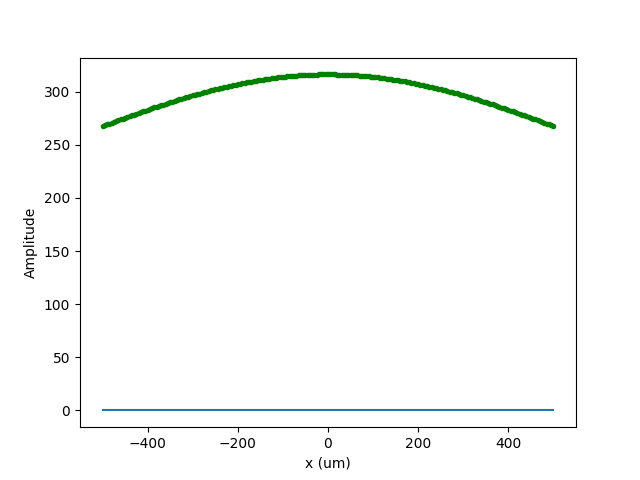

In [795]:
N = 10000

z_det = 1000

det_vec = np.array([[1, 0]])
ray_aper_coord = np.array([[0], [0]])
ray_det_theta = np.random.uniform(0, -np.pi, N)

ray_det_x = np.random.uniform(x[0], x[-1], N)
# ray_det_x = z_det * np.tan(ray_det_theta)
ray_det_z = np.ones(N) * z_det

ray_det_coord = np.array([ray_det_z, ray_det_x])

ray_vec = ray_det_coord - ray_aper_coord
ray_vec_mag = np.linalg.norm(ray_vec, axis = 0)
ray_vec_dir = ray_vec / ray_vec_mag


det_image = np.zeros((1, det_px), dtype = np.complex128)

pixel_coords_x, pixel_coords_y = get_pixel_coords(ray_det_x, np.zeros(ray_det_x.shape), det_image.shape, dx)
pixel_coords_y, pixel_coords_x = np.round((pixel_coords_y, pixel_coords_x)).astype(int)

sy, sx = det_image.shape

mask = np.logical_and(
    np.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sy
    ),
    np.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sx
    )
)

flat_icds = np.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    det_image.shape
)

print(len(flat_icds))

px_idx, counts = np.unique(flat_icds, return_counts=True)

ws = np.sqrt((N * dS0) / dN0) * np.dot(ray_vec_dir.T, det_vec.T).T
dN0 = 1 # Number of rays per pixel in point source
dS0 = 1

ray_det_x = ray_det_x[mask]
ray_det_z = ray_det_z[mask]

ray_det_coord = np.array([ray_det_z, ray_det_x])

ray_vec = ray_det_coord - ray_aper_coord
ray_vec_mag = np.linalg.norm(ray_vec, axis = 0)
ray_vec_dir = ray_vec / ray_vec_mag

ray_angle = np.arctan2(ray_vec_dir[1, :], ray_vec_dir[0, :])

# factor = 1j * np.sqrt(wavelength) / (wavelength * np.sqrt(ray_vec_mag))
factor = 1 / (np.sqrt(ray_vec_mag))

# the dot product between the ray and detector vector.
dS1 = np.dot(ray_vec_dir.T, det_vec.T).T

# See Chapter 2 of Marco Mout thesis - 2.97 onwards
ws = np.sqrt((N * dS0) / dN0) * np.dot(ray_vec_dir.T, det_vec.T).T
wp = np.sqrt((N * dS1) / dN1)
wi = np.sqrt(1 / (np.dot(ray_vec_dir.T, det_vec.T).T))

ray_amplitude = factor * ws * wi * wp

# for i in range(det_image.shape[0]):
#     det_image[i] += 
np.add.at(
    det_image.ravel(),
    flat_icds,
    ray_amplitude.ravel(),
)

det_image *= (1 / (counts))

plt.figure()
plt.plot(x, np.abs(U_Det[-1, :]))
plt.plot(x, np.abs(det_image[0, :]), '.g')
plt.xlabel('x (um)')
plt.ylabel('Amplitude')

print(np.average((np.average(np.abs(det_image[0, :]))) / np.abs(U_Det[-1, :])))



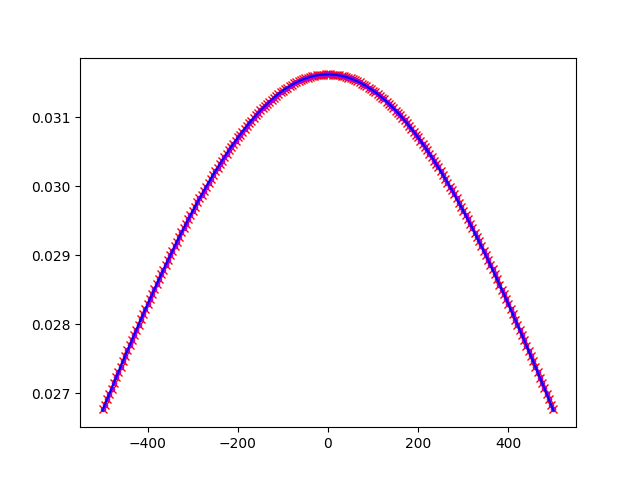

In [796]:

# plt.plot(x, counts)


U0 = (z_prop / ray_vec_mag) * 1 / np.sqrt(r_circ)
I0 = U0**2
dS0 = r_circ
dS1 = np.dot(ray_vec_dir.T, det_vec.T).T
I1 = (I0 * (dS0 / (dS1)))  * np.dot(ray_vec_dir.T, det_vec.T).T * (1 / ray_vec_mag)
U1 = np.sqrt(I1)


for i in range(len(det_image[0, :])):
    ith_indices = np.argwhere(flat_icds==i)[:, 0]
    U1_at_ith_pixel = U1[:, ith_indices]
    U1_average = np.average(U1_at_ith_pixel)
    det_image[0, i] = U1_average

det_image_add_at = np.zeros_like(det_image)

np.add.at(
    det_image_add_at.ravel(),
    flat_icds,
    U1.ravel(),
)

det_image_add_at[0, np.unique(flat_icds)] *= (1 / (counts))


plt.figure()
plt.plot(x, np.abs(det_image[0, :]), 'xr')
plt.plot(x, np.abs(det_image_add_at[0, :]), '.m')
plt.plot(x, np.abs(U_Det[-1, :]), '-b')